In [ ]:
import os
import zipfile
import glob
import json
import librosa
import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from scipy.fft import fft
from scipy.signal import find_peaks

In [ ]:
extract_path = "/Users/yida_song@mines.edu/guitar"

# List all .jams and .wav files
annotation_files = sorted(glob.glob(f"{extract_path}/annotation/*.jams"))
mic_audio_files = sorted(glob.glob(f"{extract_path}/audio_mono-mic/*.wav"))
pickup_audio_files = sorted(glob.glob(f"{extract_path}/audio_mono-pickup_mix/*.wav"))

print(f"📂 Found {len(annotation_files)} .jams files")
print(f"📂 Found {len(mic_audio_files)} microphone-recorded .wav files")
print(f"📂 Found {len(pickup_audio_files)} pickup-recorded .wav files")

# Print sample files
print("Sample .jams file:", annotation_files[0] if annotation_files else "None")
print("Sample microphone .wav file:", mic_audio_files[0] if mic_audio_files else "None")
print("Sample pickup .wav file:", pickup_audio_files[0] if pickup_audio_files else "None")

📂 Found 360 .jams files
📂 Found 360 microphone-recorded .wav files
📂 Found 360 pickup-recorded .wav files
Sample .jams file: /Users/yida_song@mines.edu/guitar/annotation/00_BN1-129-Eb_comp.jams
Sample microphone .wav file: /Users/yida_song@mines.edu/guitar/audio_mono-mic/00_BN1-129-Eb_comp_mic.wav
Sample pickup .wav file: /Users/yida_song@mines.edu/guitar/audio_mono-pickup_mix/00_BN1-129-Eb_comp_mix.wav


In [ ]:
# STEP 3: LOAD A SAMPLE ANNOTATION FILE (CHORD LABELS)
if len(annotation_files) > 0:
    sample_jam_file = annotation_files[0]
    with open(sample_jam_file, "r") as f:
        jam_data = json.load(f)

    print(f"✅ Successfully loaded {sample_jam_file}")
else:
    print("🚨 No .jams files found!")


# STEP 4: EXTRACT CHORD ANNOTATIONS
def extract_chords(jam_file):
    """ Extract chord annotations from a .jams file """
    with open(jam_file, "r") as f:
        jam_data = json.load(f)

    chord_list = []
    for annotation in jam_data["annotations"]:
        if annotation["namespace"] == "chord":
            for obs in annotation["data"]:
                start_time = obs["time"]
                duration = obs["duration"]
                end_time = start_time + duration
                chord_label = obs["value"]
                chord_list.append((start_time, end_time, chord_label))
            break

    return chord_list


# Extract chords from the first file
chords = extract_chords(sample_jam_file)

# Print first 10 chords
print("\n🎸 Sample Chord Annotations:")
for start, end, chord in chords[:10]:
    print(f"🕒 {start:.2f}s → {end:.2f}s | 🎵 Chord: {chord}")


# STEP 5: LOAD & PLAY A SAMPLE AUDIO FILE
if len(mic_audio_files) > 0 and len(pickup_audio_files) > 0:
    sample_mic_audio_file = mic_audio_files[0]
    sample_pickup_audio_file = pickup_audio_files[0]

    y_mic, sr = librosa.load(sample_mic_audio_file, sr=22050)
    y_pickup, sr = librosa.load(sample_pickup_audio_file, sr=22050)

    print(f"✅ Loaded Microphone Audio: {sample_mic_audio_file} | Sample Rate: {sr} Hz")
    print(f"✅ Loaded Pickup Audio: {sample_pickup_audio_file} | Sample Rate: {sr} Hz")

    # You can play these in a Colab/Jupyter environment
    print("\n🎵 Playing Microphone Recording:")
    ipd.Audio(y_mic, rate=sr)

    print("\n🎵 Playing Pickup Recording:")
    ipd.Audio(y_pickup, rate=sr)
else:
    print("🚨 No audio files found!")

✅ Successfully loaded /Users/yida_song@mines.edu/guitar/annotation/00_BN1-129-Eb_comp.jams

🎸 Sample Chord Annotations:
🕒 0.00s → 7.44s | 🎵 Chord: D#:maj
🕒 7.44s → 11.16s | 🎵 Chord: G#:maj
🕒 11.16s → 14.88s | 🎵 Chord: D#:maj
🕒 14.88s → 16.74s | 🎵 Chord: A#:maj
🕒 16.74s → 18.60s | 🎵 Chord: G#:maj
🕒 18.60s → 22.32s | 🎵 Chord: D#:maj
✅ Loaded Microphone Audio: /Users/yida_song@mines.edu/guitar/audio_mono-mic/00_BN1-129-Eb_comp_mic.wav | Sample Rate: 22050 Hz
✅ Loaded Pickup Audio: /Users/yida_song@mines.edu/guitar/audio_mono-pickup_mix/00_BN1-129-Eb_comp_mix.wav | Sample Rate: 22050 Hz

🎵 Playing Microphone Recording:

🎵 Playing Pickup Recording:


In [ ]:
# STEP 6: SEGMENT AUDIO BASED ON CHORD TIMESTAMPS
def segment_audio(audio_file, chord_data, sr=22050):
    """ Splits an audio file into segments based on chord labels """
    y, _ = librosa.load(audio_file, sr=sr)
    segments = []

    for start, end, chord in chord_data:
        start_sample = int(start * sr)
        end_sample = int(end * sr)

        if end_sample <= start_sample:
            continue  # Skip invalid segments

        segment = y[start_sample:end_sample]
        segments.append((segment, chord))

    return segments

# Segment the sample audio files
mic_segments = segment_audio(sample_mic_audio_file, chords)
pickup_segments = segment_audio(sample_pickup_audio_file, chords)

print(f"✅ Extracted {len(mic_segments)} microphone segments")
print(f"✅ Extracted {len(pickup_segments)} pickup segments")

✅ Extracted 6 microphone segments
✅ Extracted 6 pickup segments


In [ ]:
X1_data = []  # mic data
Y1_labels = []  # Chord labels
X2_data = []  # pickup data
Y2_labels = []  # Chord labels

for mic_audio_file, pickup_audio_file, annotation_file in zip(mic_audio_files, pickup_audio_files, annotation_files):
    chords = extract_chords(annotation_file)  # custom function => [(start, end, chord_label), ...]

    y_mic, sr = librosa.load(mic_audio_file, sr=22050)
    y_pickup, sr = librosa.load(pickup_audio_file, sr=22050)

    for start, end, chord_label in chords:
        start_sample, end_sample = int(start * sr), int(end * sr)
        # Skip if slice is zero-length or invalid
        if end_sample <= start_sample:
            continue

        mic_segment = y_mic[start_sample:end_sample]
        pickup_segment = y_pickup[start_sample:end_sample]

        X1_data.append(mic_segment)
        Y1_labels.append(chord_label)

        X2_data.append(pickup_segment)
        Y2_labels.append(chord_label)


In [ ]:
count_dict = Counter(Y1_labels)

print(count_dict)

Counter({'F:maj': 288, 'G:maj': 252, 'G#:maj': 228, 'C#:maj': 228, 'C:maj': 228, 'D#:maj': 216, 'E:maj': 216, 'A#:maj': 204, 'D:maj': 204, 'F#:maj': 192, 'B:maj': 192, 'A:maj': 192, 'E:min': 120, 'G:min': 120, 'C#:min': 96, 'D#:7': 96, 'G#:min': 96, 'A#:min': 96, 'F#:7': 72, 'B:min': 72, 'F:min': 72, 'A:min': 72, 'C:7': 72, 'D:min': 72, 'A:7': 48, 'A#:hdim7': 48, 'C#:7': 48, 'D#:min': 48, 'C:min': 48, 'F:7': 48, 'F#:min': 48, 'G:hdim7': 48, 'C#:hdim7': 24, 'F:hdim7': 24, 'A#:7': 24, 'A:hdim7': 24, 'D:7': 24, 'G#:7': 24, 'C:hdim7': 24, 'E:7': 24, 'G#:hdim7': 24, 'E:hdim7': 24})


In [ ]:
cowboy_chords = ['F:maj', 'G:maj', 'G#:maj', 'C#:maj', 'C:maj', 'D#:maj','E:maj','A#:maj','D:maj','F#:maj','B:maj','A:maj']
filtered_X1, filtered_Y1 = [], []

for i in range(len(Y1_labels)):
    if Y1_labels[i] in cowboy_chords:
        filtered_X1.append(X1_data[i])
        filtered_Y1.append(Y1_labels[i])


In [ ]:
len(filtered_X1)

2640

In [ ]:
filtered_Y1[0]

'D#:maj'

In [ ]:
frequencies = [261.63, 277.18, 293.66, 311.13, 329.63, 349.23, 369.99, 392, 415.30, 440, 466.16, 493.88]

def extract_features(signal, frequencies=frequencies, sr=22050):
    # Compute the FFT
    n = len(signal)
    fft_result = fft(signal)
    fft_magnitude = np.abs(fft_result[:n // 2])  # Magnitude of the FFT
    freqs = np.linspace(0, sr / 2, n // 2)  # Frequency array

    # Define the frequency range for search
    frequency_range = 5  # Frequency search range ±5Hz

    # Initialize feature array
    features = []

    # Calculate the threshold
    threshold = 15 * np.mean(fft_magnitude)  # Set the threshold as 15 times the mean magnitude

    # Process each key frequency
    for freq in frequencies:
        # Find the index range around the key frequency
        low_idx = np.searchsorted(freqs, freq - frequency_range, side='left')
        high_idx = np.searchsorted(freqs, freq + frequency_range, side='right')
        # Find the maximum amplitude within the frequency range
        max_amplitude = np.max(fft_magnitude[low_idx:high_idx])
        # Compare with threshold and compute ratio if above threshold
        if max_amplitude > threshold:
            features.append(max_amplitude / threshold)
        else:
            features.append(0.0)  # or None

    return features

def plot_spectrum_with_keys(signal, sr=22050):
    # Calculate the FFT
    n = len(signal)
    fft_result = fft(signal)
    fft_magnitude = np.abs(fft_result[:n//2])  # Magnitude of the FFT
    freqs = np.linspace(0, sr/2, n//2)  # Frequency array

    # Calculate threshold
    threshold = 15 * np.mean(fft_magnitude)

    # List of key frequencies
    key_frequencies = [261.63, 277.18, 293.66, 311.13, 329.63, 349.23, 369.99, 392, 415.30, 440, 466.16, 493.88]
    key_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

    # Plot the spectrum
    plt.figure(figsize=(10, 5))
    plt.plot(freqs, fft_magnitude, label='Magnitude Spectrum')
    plt.xlim(0, 550)  # Limiting frequency display to 0-550 Hz
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Frequency Spectrum (0-550 Hz) with Key Frequencies Marked')

    # Plot threshold line
    plt.axhline(y=threshold, color='green', linestyle='--', linewidth=1, label='Threshold (15x Mean Magnitude)')

    # Mark key frequencies within 0-550 Hz
    for i, freq in enumerate(key_frequencies):
        if freq <= 550:
            plt.axvline(x=freq, color='r', linestyle='--', linewidth=0.8)
            plt.text(freq, plt.ylim()[1]*0.9, key_labels[i], rotation=45, ha='right')

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
features_list = []

for signal in filtered_X1:
    features = extract_features(signal)
    features_list.append(features)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(features_list, filtered_Y1, test_size=0.2, random_state=42)

In [ ]:
model = GaussianNB()

model.fit(X_train, y_train)

GaussianNB()

In [ ]:
labels_pred = model.predict(X_val)

accuracy = accuracy_score(y_val, labels_pred)
print(f"Accuracy of the Naive Bayes classifier: {accuracy:.2f}")

Accuracy of the Naive Bayes classifier: 0.50


D#:maj
Feature vector (1 if above threshold, 0 otherwise): [0.0, 0.0, np.float32(6.204611), np.float32(14.563292), 0.0, 0.0, 0.0, np.float32(15.871016), 0.0, 0.0, np.float32(2.3304846), 0.0]


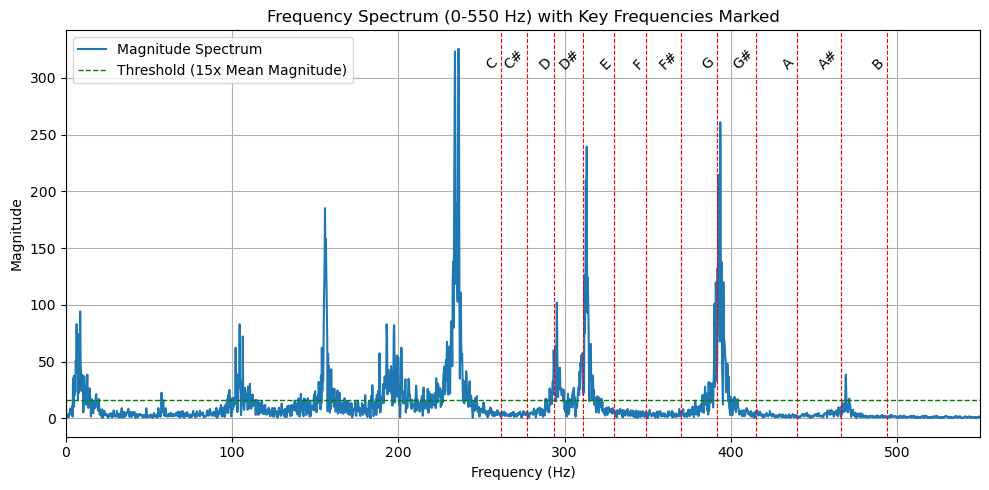

In [ ]:
i = 2
signal = filtered_X1[i]
print(filtered_Y1[i])
features = extract_features(signal)
print("Feature vector (1 if above threshold, 0 otherwise):", features)

plot_spectrum_with_keys(signal)